## 0. 세팅

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


* 활성화 함수로 tahn을 사용.
* tanh를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에 Normalize를 해줄 때 127.5로 나눈 뒤 1을 빼준다.

In [4]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [5]:
# min 과 max 사이의 값이 -1과 1로 나와야 합니다.
x_train.min(), x_train.max()

(-1.0, 1.0)

* x_train은 28 * 28 로 되어 있어서 1차원으로 Flatten하게 펴준다.

In [6]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [7]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

## 1. Hyperparameters

* nosie_dim을 설정한다.
* gan에 입력되는 무작위 값 noise에 대한 demension을 설정함.
* noise_dim은 generator의 input으로 들어간다.

In [9]:
NOISE_DIM = 10
adam = Adam(lr=0.0002, beta_1=0.5)

## 2. Generator

* generator 정의하기

In [10]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

## 3. Discriminator
* Discriminator 정의하기

In [12]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

* discriminator는 꼭 compile 해야 한다.

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

## 4. GAN
* generator과 discriminator을 연결한다.
* discriminator는 학습을 하지 않으며 generator만 학습하도록 한다.

In [15]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

* gan 모델 정의하기

In [16]:
gan = Model(gan_input, output)

In [17]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


# 5. Compile

In [18]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

## 6. Batch

* 이미지 batch 생성

In [19]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

## 7. 시각화를 위한 유틸 함수 정의

In [20]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 8. 학습

In [21]:
BATCH_SIZE = 128
EPOCHS= 50

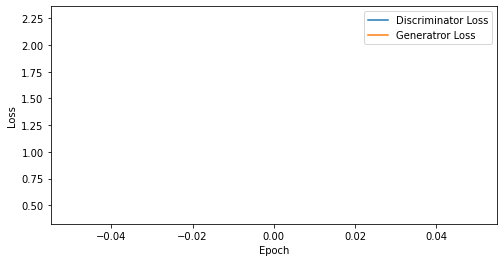

epoch: 1, Discriminator Loss: 0.4198954701423645, Generator Loss: 2.2694222927093506


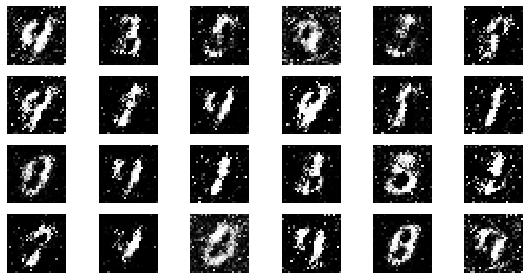

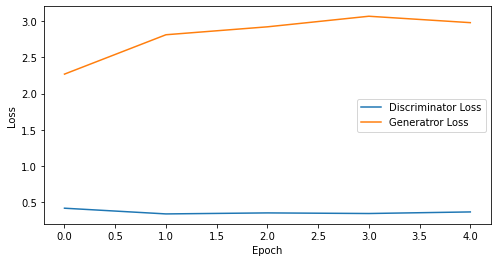

epoch: 5, Discriminator Loss: 0.36628793478012084, Generator Loss: 2.8100697994232178


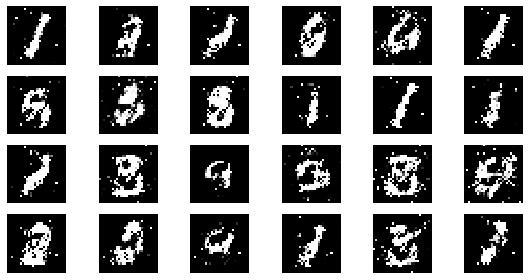

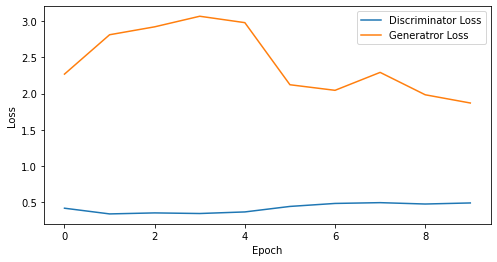

epoch: 10, Discriminator Loss: 0.42282072007656096, Generator Loss: 2.4367612481117247


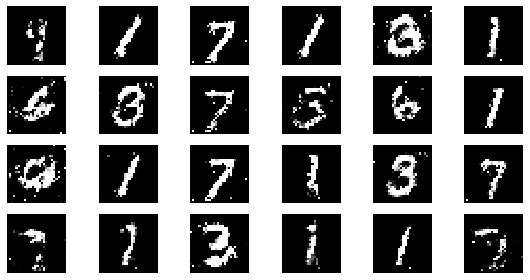

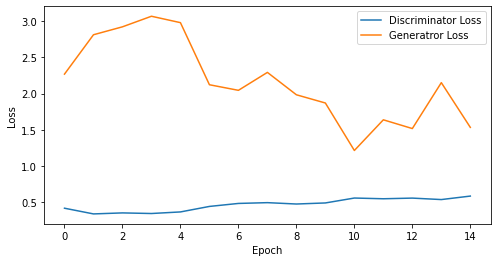

epoch: 15, Discriminator Loss: 0.4682710866133372, Generator Loss: 2.161854346593221


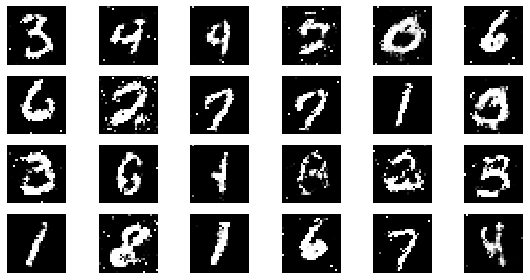

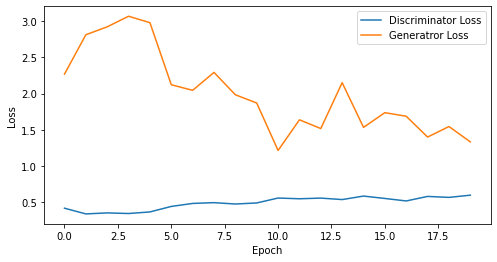

epoch: 20, Discriminator Loss: 0.4924744263291359, Generator Loss: 2.00683074593544


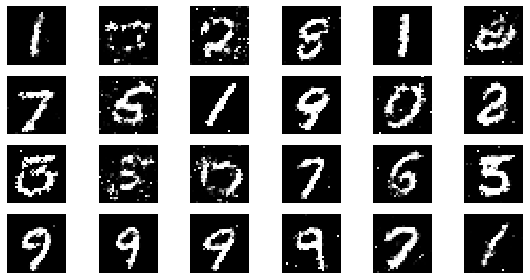

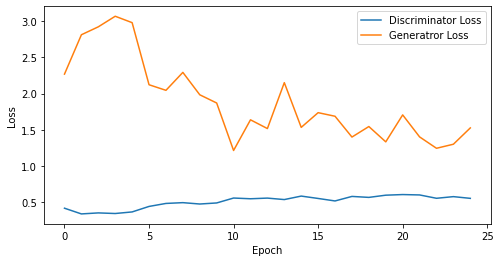

epoch: 25, Discriminator Loss: 0.5101055371761322, Generator Loss: 1.8929395151138306


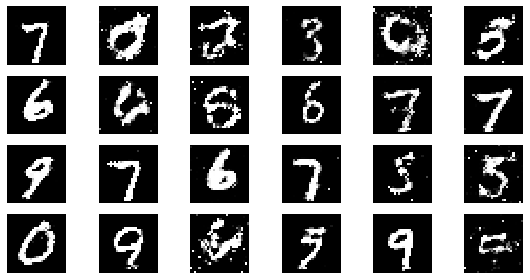

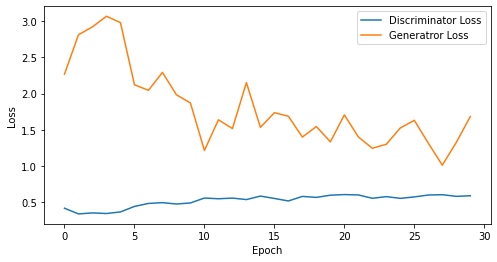

epoch: 30, Discriminator Loss: 0.5237226575613022, Generator Loss: 1.8099316596984862


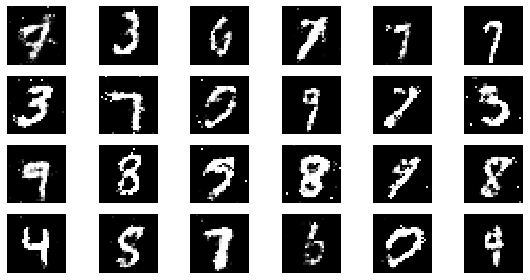

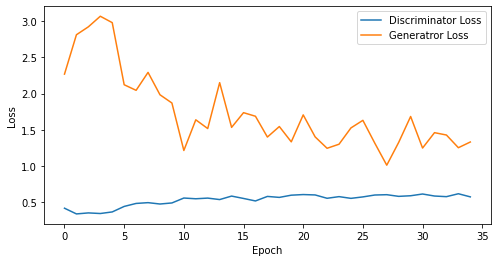

epoch: 35, Discriminator Loss: 0.5340084544249943, Generator Loss: 1.74360899244036


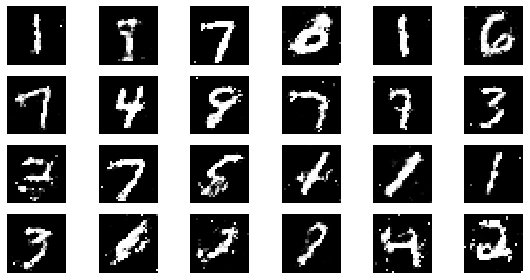

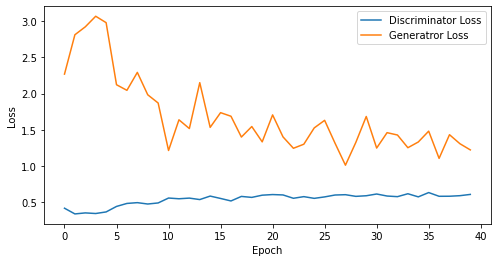

epoch: 40, Discriminator Loss: 0.5424499742686748, Generator Loss: 1.6895915895700455


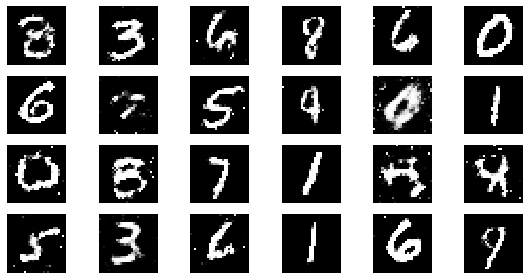

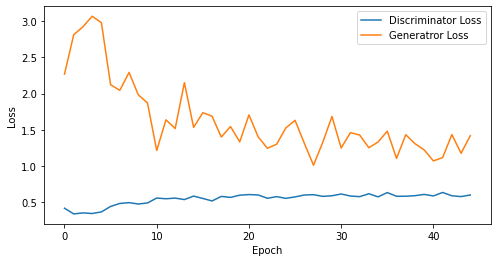

epoch: 45, Discriminator Loss: 0.5488536338011424, Generator Loss: 1.6401547617382473


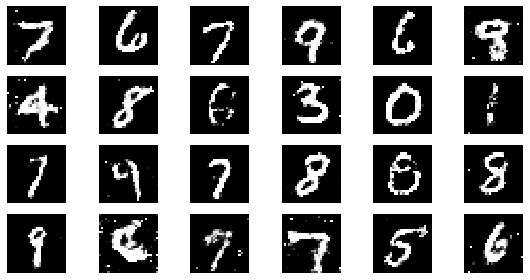

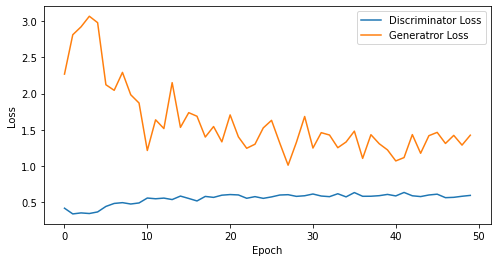

epoch: 50, Discriminator Loss: 0.5525646203756333, Generator Loss: 1.614547758102417


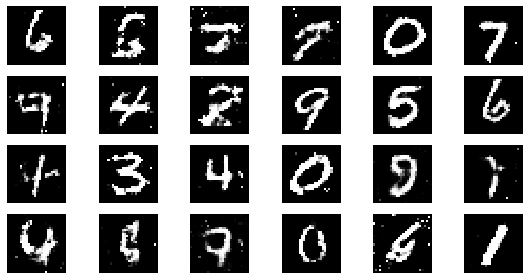

In [22]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)